In [9]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [11]:
#STEP-1 — load dataset
import pandas as pd

df = pd.read_csv("data/india_states/labeled_dataset.csv")
print("Rows:", len(df))


Rows: 953755


In [13]:
#STEP-2 — Define feature columns + target
feature_cols = [
    'value', 'hour', 'month', 'weekday',
    'recent_spike','pm_trend_mean_3h','pm_trend_mean_6h',
    'near_road','near_industry','near_farmland','near_dumpyard','near_landfill',
    'latitude','longitude'
]

X = df[feature_cols]
y = df['pollution_source']

In [17]:
#STEP-3 — Re-create Label Encoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

#STEP-4 — Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [19]:
#STEP 4-Define a fast tuning space
xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)

param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5]
}

In [21]:
#STEP-5 — RandomizedSearch (8 fast trials)
xgb_rand = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=8,          # fast but effective
    scoring='f1_macro',
    cv=2,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

xgb_rand.fit(X_train, y_train)

print("Best XGBoost Parameters:")
print(xgb_rand.best_params_)

xgb_best = xgb_rand.best_estimator_

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best XGBoost Parameters:
{'subsample': 0.6, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}


In [29]:
#STEP-6 — Save Tuned XGBoost Model
import os, joblib
os.makedirs("models", exist_ok=True)

joblib.dump(xgb_best, "models/source_classifier_xgb_tuned.pkl")
joblib.dump(le, "models/label_encoder.pkl")

print("Tuned XGBoost model saved successfully")

Tuned XGBoost model saved successfully



XGBoost Accuracy: 88.66%

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.94      0.74      0.83      1073
           1       0.86      0.73      0.79     37008
           2       0.90      0.95      0.92    129872
           3       0.83      0.77      0.80     18445
           4       0.93      0.88      0.90      4353

    accuracy                           0.89    190751
   macro avg       0.89      0.81      0.85    190751
weighted avg       0.89      0.89      0.88    190751



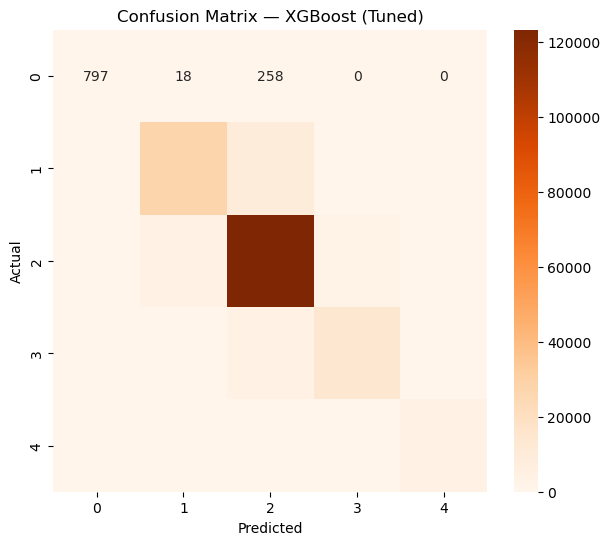

In [33]:
#STEP-7 — Evaluate (Accuracy + Metrics)
from sklearn.metrics import accuracy_score, classification_report

y_pred_xgb = xgb_best.predict(X_test)

print(f"\nXGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb)*100:.2f}%\n")

print("Classification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

#STEP-8 — Confusion Matrix (XGBoost)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(7,6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — XGBoost (Tuned)")
plt.show()


XGBoost Feature Importance:
near_industry       0.327151
hour                0.157402
near_landfill       0.092553
near_dumpyard       0.081127
value               0.071460
longitude           0.052791
near_farmland       0.051832
latitude            0.051200
recent_spike        0.043442
month               0.026840
pm_trend_mean_3h    0.025233
pm_trend_mean_6h    0.016903
weekday             0.002065
near_road           0.000000
dtype: float32


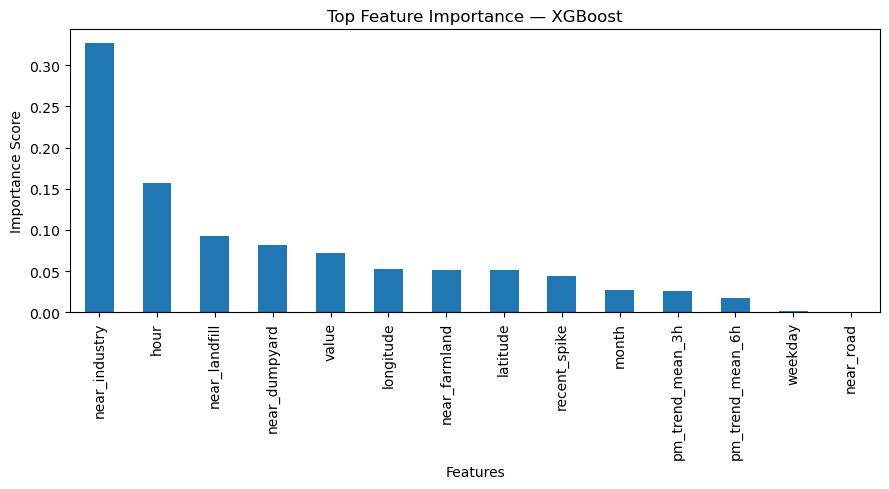

In [27]:
#Feature importance
import pandas as pd
import matplotlib.pyplot as plt

importance_xgb = pd.Series(
    xgb_best.feature_importances_,
    index=feature_cols
).sort_values(ascending=False)

print("\nXGBoost Feature Importance:")
print(importance_xgb)

plt.figure(figsize=(9,5))
importance_xgb.head(15).plot(kind='bar')
plt.title("Top Feature Importance — XGBoost")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.tight_layout()
plt.show()